# LEAPS Data Exploration

The LEAPS data is a collection of complete programs in the LEAPS Karel DSL for controlling an agent in the Karel environment.
My goal is to explore how the programs in the dataset perform on the Karel tasks to serve as a baseline dataset. This
will be compared against the dataset being generated using a random policy for the Karel tasks.

## Read data

In [1]:
import tables as tb

leaps_data = tb.File('leaps/data/data-001.hdf5', 'r')

### Output tree structure to file

Takes ~5 mins to run

In [ ]:
leaps_tree = str(leaps_data)
with open('leaps_tree.txt', 'w') as f:
    f.write(leaps_tree)

In [2]:
data_info = leaps_data.get_node('/data_info')

for node in data_info._f_iter_nodes():
    try:
        print(node._v_name, node.read())
    except:
        pass

max_demo_length 20
max_program_length 50
min_demo_length 1
min_program_length 7
num_action_tokens 5
num_demo_per_program 10
num_program_tokens 50
num_test 7500
num_train 35000
num_val 7500


/home/akrish13/miniconda3/envs/decision-transformer-microrts/lib/python3.11/site-packages/tables/group.py:1160: UserWarning: problems loading leaf ``/data_info/dsl_type``::

  variable length strings are not supported yet

The leaf will become an ``UnImplemented`` node.
  warnings.warn(


Examining the tree structure reveals no indication of how the train, validation and test sets are split. Is it simply that the first `num_train` programs are in the train set, and so on?

In [3]:
p1 = leaps_data.get_node('/no_0_prog_len_19_max_s_h_len_5')
for node in p1._f_iter_nodes():
    try:
        print(node._v_name)
    except:
        pass

a_h
a_h_len
program
s_h
s_h_len


In [4]:
p1_prog = leaps_data.get_node('/no_0_prog_len_19_max_s_h_len_5')
prog = p1_prog._f_get_child('program').read()
print(p1_prog._v_name.split('_')[1], prog)

0 [ 0  1  2  6  4  6  4 49 32 41 33 47 31 27  9  4 10 48  3]


## Produce dataset

In [5]:
import sys

sys.path.insert(0, 'leaps')

from leaps.prl_gym.exec_env import ExecEnv2
from leaps.pretrain.get_karel_config import get_karel_task_config

/home/akrish13/miniconda3/envs/decision-transformer-microrts/lib/python3.11/site-packages/gymnasium/envs/registration.py:693: UserWarning: WARN: Overriding environment CartPoleDiscrete-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


Takes ~500 mins to run

In [ ]:
programs = []
indices = []
prog_lens = []
tasks = ['cleanHouse', 'harvester', 'fourCorners', 'randomMaze', 'stairClimber', 'topOff']
rewards = { task: [] for task in tasks }

for node in leaps_data.walk_nodes():
    try:
        if 'program' in node:
            prog_node = node
            prog_num = prog_node._v_name.split('_')[1]
            program_seq = prog_node._f_get_child('program').read()
            for idx, task in enumerate(tasks):
                karel_env = ExecEnv2(get_karel_task_config(task))
                if idx == 0:
                    program_str = karel_env.dsl.intseq2str(program_seq)
                    indices.append(prog_num)
                    programs.append(program_str)
                    prog_lens.append(prog_len(program_str))
                reward, _ = karel_env.reward(program_seq)
                rewards[task].append(reward)
    except:
        pass

df = pd.DataFrame({
    'program': programs,
    'prog_len': prog_lens,
    **{f'{task}_reward': rewards[task] for task in tasks}
})

df.to_csv('leaps_data.csv', index_label='indices')

## Data Exploration

In [17]:
import pandas as pd

df = pd.read_csv('leaps_data.csv')
df.describe()

,indices,prog_len,cleanHouse_reward,harvester_reward,fourCorners_reward,randomMaze_reward,stairClimber_reward,topOff_reward
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,24999.500000,19.301080,0.100048,0.086496,0.102710,0.197774,0.102446,0.208486
std,14433.901067,5.961726,0.001919,0.083187,0.026176,0.112246,0.033696,0.101515
min,0.000000,7.000000,0.100000,-1.261111,0.100000,0.100000,0.100000,0.100000
25%,12499.750000,15.000000,0.100000,0.100000,0.100000,0.100000,0.100000,0.118182
50%,24999.500000,19.000000,0.100000,0.100000,0.100000,0.100000,0.100000,0.172727
75%,37499.250000,23.000000,0.100000,0.100000,0.100000,0.300000,0.100000,0.272727
max,49999.000000,50.000000,0.200000,0.655556,1.100000,1.100000,1.100000,1.100000


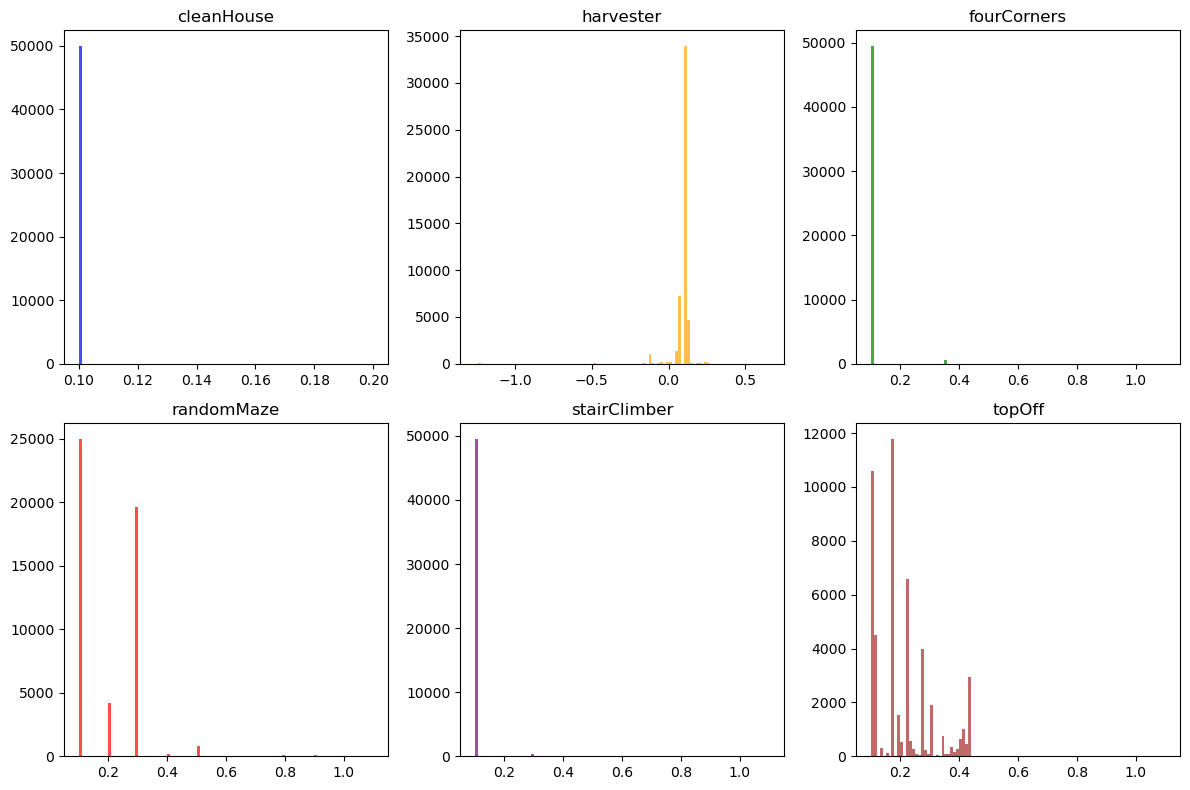

In [18]:
import matplotlib.pyplot as plt

num_bins = 100

# Create a figure and arrange subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

# Plot the distributions in each subplot
axes[0, 0].hist(df.cleanHouse_reward, bins=num_bins, color='blue', alpha=0.7)
axes[0, 0].set_title('cleanHouse')

axes[0, 1].hist(df.harvester_reward, bins=num_bins, color='orange', alpha=0.7)
axes[0, 1].set_title('harvester')

axes[0, 2].hist(df.fourCorners_reward, bins=num_bins, color='green', alpha=0.7)
axes[0, 2].set_title('fourCorners')

axes[1, 0].hist(df.randomMaze_reward, bins=num_bins, color='red', alpha=0.7)
axes[1, 0].set_title('randomMaze')

axes[1, 1].hist(df.stairClimber_reward, bins=num_bins, color='purple', alpha=0.7)
axes[1, 1].set_title('stairClimber')

axes[1, 2].hist(df.topOff_reward, bins=num_bins, color='brown', alpha=0.7)
axes[1, 2].set_title('topOff')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
anomalous = df[df.filter(like='_reward').apply(lambda col: (col < 0) | (col > 1)).any(axis=1)]
print(anomalous)

anomalous.to_csv('anomalous.csv')

In [ ]:
tasks = ['cleanHouse', 'harvester', 'fourCorners', 'randomMaze', 'stairClimber', 'topOff']
df[df['harvester_reward'] == df['harvester_reward'].min()].programs.values[0]

In [ ]:
max_len = df[df['prog_len'] == df['prog_len'].max()].programs.values[0]
print('\n'.join([f'{idx}, {token}' for idx, token in enumerate(max_len.split())]))

In [ ]:
from collections import Counter
print(Counter(df['fourCorners_reward']))